# Chest X-ray classification of Pneumonia Patients
We make an initial attempt to build a simple CNN for this task given the limited resources of the local computer.
Then we will move to a cloud based solution.

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from PIL import Image

In [2]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation',
          'No Finding']
labels.sort()
print(labels)

#read the whole dataset
df = pd.read_csv("dataset/Data_Entry_2017_v2020.csv")

print('Total entries:',len(df.index))
print('No of patients:', df["Patient ID"].nunique())
df.head()


['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Total entries: 112120
No of patients: 30805


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


We process the labels so that each finding is on its own column

In [3]:
for label in labels:
    df[label] = df['Finding Labels'].map(lambda res: 1 if label in res else 0)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,0


In [4]:
# disease per unique patient plot
positive = df[df['Infiltration']==1]
unique_pos = positive['Patient ID'].unique()
negative = df[df['Infiltration']==0]
unique_neg = negative['Patient ID'].unique()
print("Patients with Infiltration:", unique_pos.size)
print("Patients without Infiltration:", unique_neg.size)

Patients with Infiltration: 8035
Patients without Infiltration: 28801


It is interesting that the sum of patients with and without Infiltration is bigger than the total number of patients. This means that some patients developed infiltration along the way.

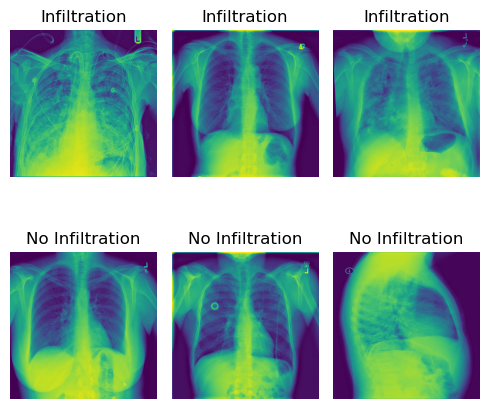

In [5]:
#Sample Infiltration and no Infiltration images:
pos_img = positive.sample(3)['Image Index'].map(lambda name: Image.open('dataset/images/'+name))
neg_img = negative.sample(3)['Image Index'].map(lambda name: Image.open('dataset/images/'+name))
fig, axes = plt.subplots(2, 3, figsize=(5,5))
for img, ax in zip(pos_img, axes[0]):
    ax.imshow(img)
    ax.set_title("Infiltration")
    ax.axis('off')
for img, ax in zip(neg_img, axes[1]):
    ax.imshow(img)
    ax.set_title("No Infiltration")
    ax.axis('off')
plt.tight_layout()
plt.show()

We create the train test split at 70 - 30 percent of the dataset. Then we further split the training set to training and validation set at 80 - 20 percent.
It is important that a given patient will only appear in one of the 3 datasets. Not achieveing this could lead to the model learning to predict by identifying the patient and not Pneumonia per se. For this we use GroupShuffeSplit.

In [6]:
from sklearn.model_selection import GroupShuffleSplit
def group_shuffle_split(df, group_col, train_size=0.8, random_state=None):
    splitter = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=random_state)

    # Split the data into train and test sets
    train_indices, test_indices = next(splitter.split(df, groups=df[group_col]))

    # Create the train and test dataframes
    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]

    return train_df, test_df
train_df, test_df = group_shuffle_split(df, 'Patient ID', 0.7, random_state=42)
train_df, val_df = group_shuffle_split(train_df, 'Patient ID', 0.8, random_state=42)

In [7]:
def validate_dataset_spill(test, val, train):
    # Get the patient IDs for each set
    train_patients = set(train['Patient ID'])
    val_patients = set(val['Patient ID'])
    test_patients = set(test['Patient ID'])

    # Check if there is any overlap between the sets
    assert len(train_patients.intersection(val_patients)) == 0, "There is an overlap of patients between the training and validation sets."
    assert len(train_patients.intersection(test_patients)) == 0, "There is an overlap of patients between the training and test sets."
    assert len(val_patients.intersection(test_patients)) == 0, "There is an overlap of patients between the validation and test sets."



We confirm that there is indeed no patient overlap:

In [8]:
validate_dataset_spill(test_df, val_df, train_df)

Evaluating the percentages of Pneumonia in each dataset we see that it exist in similar percentages in all the created datasets. 

In [9]:
def print_infiltraion_percentage(df, name):
    total_count = len(df)
    infiltration_count = len(df[df['Infiltration'] == 1])
    percentage = infiltration_count / total_count * 100
    print('Dataset:', name)
    print(f"Total entries: {total_count}")
    print(f"Total patients: {len(set(df['Patient ID'].values))}")
    print(f"Infiltration percentage in dataset: {percentage:.2f}%")
    print()

print_infiltraion_percentage(df, "Total")
print_infiltraion_percentage(train_df, "Train")
print_infiltraion_percentage(val_df, "Validation")
print_infiltraion_percentage(test_df,"Test")

Dataset: Total
Total entries: 112120
Total patients: 30805
Infiltration percentage in dataset: 17.74%

Dataset: Train
Total entries: 62348
Total patients: 17250
Infiltration percentage in dataset: 17.60%

Dataset: Validation
Total entries: 16218
Total patients: 4313
Infiltration percentage in dataset: 17.84%

Dataset: Test
Total entries: 33554
Total patients: 9242
Infiltration percentage in dataset: 17.96%



We create image generators for training. Test and validation sets only need rescaling. In the training set we add data augumentation with rotation by making small changes to the image.

In [10]:
def generator_create(df, batch_size, image_dir, is_train = False):
    if(is_train):
        datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
    else:
        datagen = ImageDataGenerator(
            rescale=1./255,
        )
    # binary classification has to have string labels
    df['Infiltration'] = df["Infiltration"].astype(str)
    return datagen.flow_from_dataframe(
        dataframe=df,
        directory=image_dir,
        x_col="Image Index",
        y_col="Infiltration",
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode="binary"
    )

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_dir = 'dataset/images/'
train_generator = generator_create(train_df, 32, image_dir, is_train = True)
val_generator = generator_create(val_df, 32, image_dir)
test_generator = generator_create(test_df, 64, image_dir)

2023-05-10 15:12:33.688721: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Found 62348 validated image filenames belonging to 2 classes.
Found 16218 validated image filenames belonging to 2 classes.


/tmp/ipykernel_201560/2132488911.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Infiltration'] = df["Infiltration"].astype(str)


Found 33554 validated image filenames belonging to 2 classes.


The model we create is a small one given the restricted hardware we have. A more elaborate model will be attemted on the cloud.

In [13]:
import tensorflow as tf
def get_model():
    try:
        model = tf.keras.models.load_model('simple_model.h5')
        print('Loaded saved model.')
    except:
        #Simple CNN model:
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
        print('Saved model as simple_model.h5')
        model.save('simple_model.h5')

    model.summary()
    return model



In [15]:
model = get_model()

Loaded saved model.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None

In [17]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
1949/1949 [==============================] - 3286s 2s/step - loss: 0.4653 - accuracy: 0.8235 - val_loss: 0.4531 - val_accuracy: 0.8216
Epoch 2/10
1949/1949 [==============================] - 3453s 2s/step - loss: 0.4576 - accuracy: 0.8240 - val_loss: 0.4542 - val_accuracy: 0.8216
Epoch 3/10
1949/1949 [==============================] - 3321s 2s/step - loss: 0.4573 - accuracy: 0.8240 - val_loss: 0.4534 - val_accuracy: 0.8216
Epoch 4/10
1949/1949 [==============================] - 3093s 2s/step - loss: 0.4566 - accuracy: 0.8240 - val_loss: 0.4514 - val_accuracy: 0.8216
Epoch 5/10
1949/1949 [==============================] - 3095s 2s/step - loss: 0.4560 - accuracy: 0.8240 - val_loss: 0.4504 - val_accuracy: 0.8216
Epoch 6/10
1949/1949 [==============================] - 3085s 2s/step - loss: 0.4551 - accuracy: 0.8240 - val_loss: 0.4544 - val_accuracy: 0.8216
Epoch 7/10
1949/1949 [==============================] - 3105s 2s/step - loss: 0.4541 - accuracy: 0.8240 - val_loss: 0.4519 -

In [18]:
model.save_weights('simple_model_weights.h5') 

In [19]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

525/525 [==============================] - 1116s 2s/step - loss: 0.4514 - accuracy: 0.8204
Test loss: 0.4513518810272217
Test accuracy: 0.8204088807106018


Training the model took a lot of time just for 10 epochs. Given the small number of epochs, and the few layers of the model it is expected that our model is still at chance level.

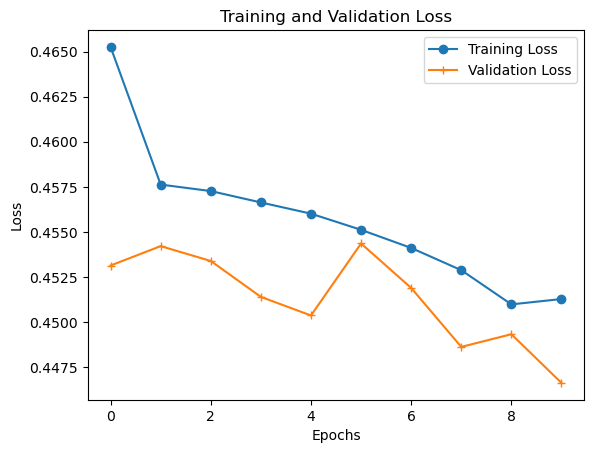

In [24]:
# Plot the loss curve
epochs = range(1, 11)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='+')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
import tensorflow as tf
#Evaluate mobilenet
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False
# Add a custom output layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=output)
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_30[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
___________________________________________________________________________________________

In [47]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
  40/1949 [..............................] - ETA: 46:20 - loss: 0.5118 - binary_accuracy: 0.8055

In [ ]:
# Evaluate the model on test data after fine tuning
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

In [ ]:
# Plot the loss curve
epochs = range(1, 11)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='+')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()